📂 Using data dir: C:\Users\Crist\Desktop\NASA\tag-and-satellite-data-model\downloads\sharks\data
Found 19 CSVs (all types). Sample:
  - 160424_2013_132346pnas_atn.csv
  - 160424_2014_141195pnas_atn.csv
  - 160424_2015_141261pnas_atn.csv
  - 160424_2015_141264pnas_atn.csv
  - 160424_2015_141268pnas_atn.csv
  - 160424_2015_141270pnas_atn.csv
  - 160424_2016_106744pnas_atn.csv
  - 160424_2016_106745pnas_atn.csv
  - 160424_2016_106746pnas_atn.csv
  - 160424_2016_106747pnas_atn.csv


,file,shark_id,n_points,mean_hours,std_hours,start,end,duration_days
4,160424_2015_141268pnas_atn.csv,160424_2015_141268,1261,2.22,4.86,2015-10-16 10:46:34+00:00,2016-02-09 18:29:51+00:00,116.3
5,160424_2015_141270pnas_atn.csv,160424_2015_141270,1980,3.46,11.07,2015-10-23 10:27:01+00:00,2016-08-03 23:10:14+00:00,285.5
1,160424_2014_141195pnas_atn.csv,160424_2014_141195,416,3.67,5.02,2014-07-13 09:38:00+00:00,2014-09-14 18:42:00+00:00,63.4
0,160424_2013_132346pnas_atn.csv,160424_2013_132346,1007,4.88,9.65,2013-07-29 09:40:21+00:00,2014-02-19 00:59:59+00:00,204.6
3,160424_2015_141264pnas_atn.csv,160424_2015_141264,727,5.22,10.15,2015-10-28 20:01:00+00:00,2016-04-03 14:14:00+00:00,157.8
16,160424_2016_165928pnas_atn.csv,160424_2016_165928,234,5.43,11.62,2016-10-19 21:47:54+00:00,2016-12-11 13:59:17+00:00,52.7
2,160424_2015_141261pnas_atn.csv,160424_2015_141261,892,6.93,16.14,2015-10-14 18:54:00+00:00,2016-06-28 05:42:00+00:00,257.4
14,160424_2016_141266pnas_atn.csv,160424_2016_141266,261,7.02,12.66,2016-09-11 06:32:05+00:00,2016-11-26 08:50:15+00:00,76.1
12,160424_2016_141263pnas_atn.csv,160424_2016_141263,216,7.46,11.10,2016-08-28 12:42:37+00:00,2016-11-03 08:28:19+00:00,66.8
13,160424_2016_141265pnas_atn.csv,160424_2016_141265,206,7.71,13.94,2016-08-27 21:11:47+00:00,2016-11-01 18:29:52+00:00,65.9



🌍 Global mean frequency: 7.02 ± 2.66 hours
≈ 8.5 minutes between samples (average)


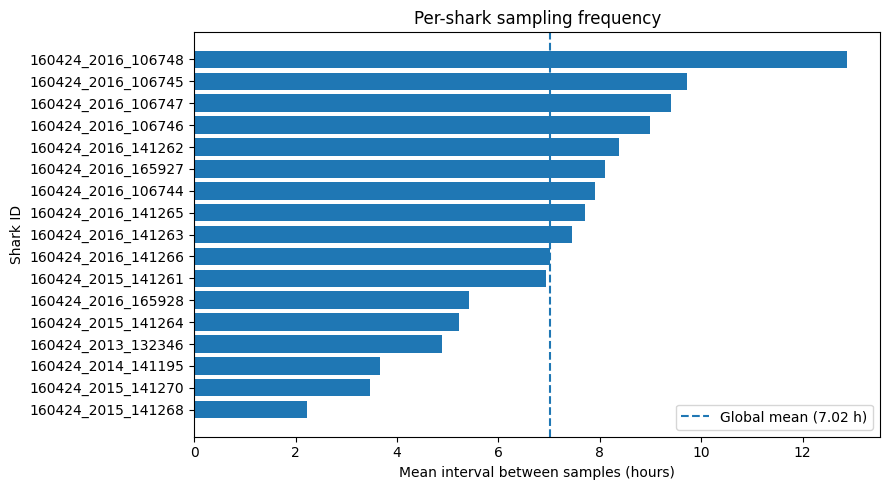

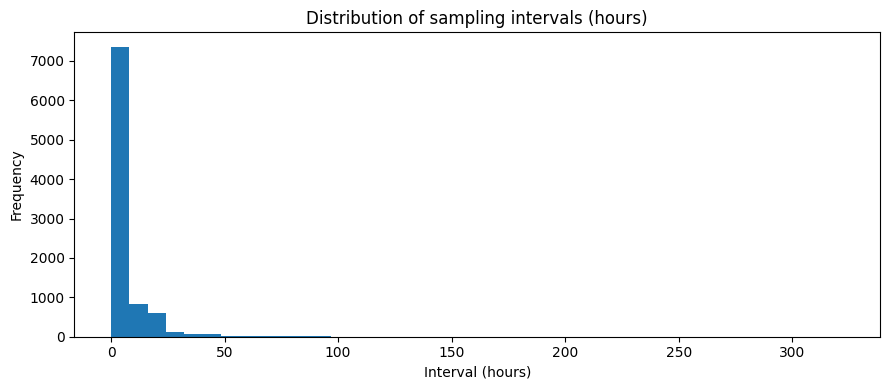

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# -------- locate data dir robustly --------
def find_data_dir():
    cwd = Path.cwd()
    candidates = [
        cwd / "downloads" / "sharks" / "data",
        cwd.parent / "downloads" / "sharks" / "data",
        cwd.parent.parent / "downloads" / "sharks" / "data",
        cwd.parent.parent.parent / "downloads" / "sharks" / "data",
    ]
    for p in candidates:
        if p.is_dir():
            return p.resolve()

    # fallback: search recursively for a folder named exactly downloads/sharks/data
    for p in cwd.rglob("*"):
        if p.is_dir() and p.parts[-3:] == ("downloads", "sharks", "data"):
            return p.resolve()
    return None

DATA_DIR = find_data_dir()

# -------- sanity checks / discovery --------
if DATA_DIR is None:
    display(pd.DataFrame({"error": ["downloads/sharks/data not found from current working dir"], 
                          "cwd": [str(Path.cwd())]}))
else:
    print(f"📂 Using data dir: {DATA_DIR}")
    all_csv = sorted([p for p in DATA_DIR.glob("*.csv")])
    print(f"Found {len(all_csv)} CSVs (all types). Sample:")
    for p in all_csv[:10]:
        print("  -", p.name)

    # keep ONLY time-series CSVs (pnas_atn), case-insensitive
    ts_csv = [p for p in all_csv if "pnas_atn" in p.name.lower()]

    if len(ts_csv) == 0:
        print("\n⚠️ No *pnas_atn* CSVs matched. Showing all CSV names to verify:")
        for p in all_csv:
            print("  -", p.name)

    # -------- compute per-shark sampling frequency --------
    results = []
    for file in ts_csv:
        try:
            df = pd.read_csv(file)
        except Exception as e:
            print(f"⚠️ Cannot read {file.name}: {e}")
            continue

        if not {"date", "id"}.issubset(df.columns):
            print(f"⚠️ Skipping {file.name}: missing 'date' or 'id' columns")
            continue

        df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
        df = df.dropna(subset=["date"]).sort_values("date")
        if len(df) < 2:
            print(f"⚠️ Skipping {file.name}: not enough rows")
            continue

        deltas_h = df["date"].diff().dt.total_seconds().dropna() / 3600.0
        mean_h, std_h = deltas_h.mean(), deltas_h.std()

        results.append({
            "file": file.name,
            "shark_id": str(df["id"].iloc[0]),
            "n_points": len(df),
            "mean_hours": mean_h,
            "std_hours": std_h,
            "start": df["date"].iloc[0],
            "end": df["date"].iloc[-1],
            "duration_days": (df["date"].iloc[-1] - df["date"].iloc[0]).total_seconds() / 86400.0
        })

    summary = pd.DataFrame(results)

    if summary.empty:
        display(pd.DataFrame({"note": ["No valid time-series CSVs processed."],
                              "data_dir": [str(DATA_DIR)]}))
    else:
        summary = summary.sort_values("mean_hours")
        display(summary.style.format({
            "mean_hours": "{:.2f}",
            "std_hours": "{:.2f}",
            "duration_days": "{:.1f}"
        }).set_caption("Sampling frequency per shark (hours)"))

        global_mean = summary["mean_hours"].mean()
        global_std = summary["mean_hours"].std()
        print(f"\n🌍 Global mean frequency: {global_mean:.2f} ± {global_std:.2f} hours")
        if pd.notna(global_mean) and global_mean > 0:
            print(f"≈ {60/global_mean:.1f} minutes between samples (average)")

        # ---- bar chart per shark ----
        plt.figure(figsize=(9, 5))
        plt.barh(summary["shark_id"], summary["mean_hours"])
        plt.axvline(global_mean, linestyle="--", label=f"Global mean ({global_mean:.2f} h)")
        plt.xlabel("Mean interval between samples (hours)")
        plt.ylabel("Shark ID")
        plt.title("Per-shark sampling frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ---- global histogram of all deltas ----
        all_deltas = []
        for file in ts_csv:
            df = pd.read_csv(file)
            if "date" not in df.columns: 
                continue
            df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
            deltas = df["date"].diff().dt.total_seconds().dropna() / 3600.0
            all_deltas.extend(deltas.tolist())

        if all_deltas:
            plt.figure(figsize=(9, 4))
            plt.hist(all_deltas, bins=40)
            plt.title("Distribution of sampling intervals (hours)")
            plt.xlabel("Interval (hours)")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()


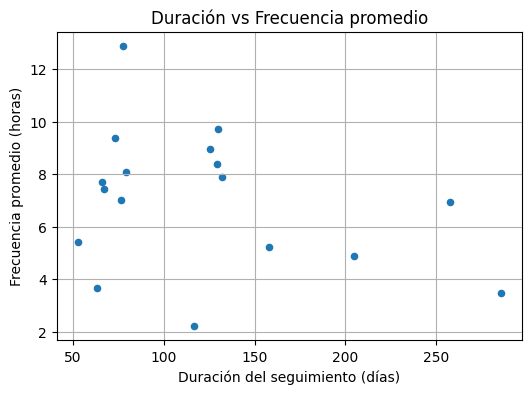

In [9]:
summary.plot.scatter("duration_days", "mean_hours", figsize=(6,4), grid=True)
plt.title("Duración vs Frecuencia promedio")
plt.xlabel("Duración del seguimiento (días)")
plt.ylabel("Frecuencia promedio (horas)")
plt.show()

In [10]:
display(summary.nsmallest(5, "std_hours"))

,file,shark_id,n_points,mean_hours,std_hours,start,end,duration_days
4,160424_2015_141268pnas_atn.csv,160424_2015_141268,1261,2.215652,4.863378,2015-10-16 10:46:34+00:00,2016-02-09 18:29:51+00:00,116.321725
1,160424_2014_141195pnas_atn.csv,160424_2014_141195,416,3.665221,5.015472,2014-07-13 09:38:00+00:00,2014-09-14 18:42:00+00:00,63.377778
0,160424_2013_132346pnas_atn.csv,160424_2013_132346,1007,4.882035,9.653439,2013-07-29 09:40:21+00:00,2014-02-19 00:59:59+00:00,204.638634
3,160424_2015_141264pnas_atn.csv,160424_2015_141264,727,5.215174,10.153949,2015-10-28 20:01:00+00:00,2016-04-03 14:14:00+00:00,157.759028
5,160424_2015_141270pnas_atn.csv,160424_2015_141270,1980,3.462719,11.068723,2015-10-23 10:27:01+00:00,2016-08-03 23:10:14+00:00,285.530012


In [11]:
summary["points_per_day"] = summary["n_points"] / summary["duration_days"]
display(summary[["shark_id","points_per_day"]].sort_values("points_per_day", ascending=False))


,shark_id,points_per_day
4,160424_2015_141268,10.840623
5,160424_2015_141270,6.934472
1,160424_2014_141195,6.563815
0,160424_2013_132346,4.920869
3,160424_2015_141264,4.608294
16,160424_2016_165928,4.442371
2,160424_2015_141261,3.464750
14,160424_2016_141266,3.429880
12,160424_2016_141263,3.232400
13,160424_2016_141265,3.126539
